###Подготовка данных

In [2]:
import cv2
from os import listdir
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Input, LeakyReLU, BatchNormalization, Conv2D, Conv2DTranspose
from keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
path = '/content/drive/MyDrive/mindset/dataset/'
path_train_orig = path + 'train/images/'
path_train_seg = path + 'train/seg/'
path_val_orig = path + 'val/images/'
path_val_seg = path + 'val/seg/'
ls_train_orig = sorted(listdir(path_train_orig))
ls_train_seg = sorted(listdir(path_train_seg))
ls_val_orig = sorted(listdir(path_val_orig))
ls_val_seg = sorted(listdir(path_val_seg))
x_train = np.array([img_to_array(load_img(
    path_train_orig + fname)) / 255. for fname in ls_train_orig])
#x_train = np.array([cv2.imread(path_train_orig + fname,
                        #cv2.IMREAD_COLOR) / 255. for fname in ls_train_orig])
y_train = np.array([img_to_array(load_img(path_train_seg + fname,
                    color_mode="grayscale")) / 255. for fname in ls_train_seg])
#y_train = np.array([cv2.imread(path_train_seg + fname,
                        #cv2.IMREAD_GRAYSCALE) / 255. for fname in ls_train_seg])
x_val = np.array([img_to_array(load_img(
    path_val_orig + fname)) / 255. for fname in ls_val_orig])
#x_val = np.array([cv2.imread(path_val_orig + fname,
                        #cv2.IMREAD_COLOR) / 255. for fname in ls_val_orig])
y_val = np.array([img_to_array(load_img(path_val_seg + fname,
                      color_mode="grayscale")) / 255. for fname in ls_val_seg])
#y_val = np.array([cv2.imread(path_val_seg + fname,
                        #cv2.IMREAD_GRAYSCALE) / 255. for fname in ls_val_seg])
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((417, 640, 640, 3), (417, 640, 640, 1), (55, 640, 640, 3), (55, 640, 640, 1))

### Модель

In [4]:
model = Sequential()
model.add(Input(x_train.shape[1:]))
inc = 5
for _ in range(4):
  inc += 1
  model.add(Conv2D(2 ** inc, 4, strides=2, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
for _ in range(4):
  inc -= 1
  model.add(Conv2DTranspose(2 ** inc, 4, strides=2, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 320, 320, 64)      3136      
                                                                 
 batch_normalization (BatchN  (None, 320, 320, 64)     256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 320, 320, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 160, 160, 128)     131200    
                                                                 
 batch_normalization_1 (Batc  (None, 160, 160, 128)    512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 160, 160, 128)     0

### Обучение

In [5]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=16, epochs=64, verbose=1,
                    validation_data=(x_val, y_val))

Epoch 1/64
27/27 [==============================] - 55s 1s/step - loss: 0.3920 - accuracy: 0.8335 - val_loss: 0.4558 - val_accuracy: 0.8726
Epoch 2/64
27/27 [==============================] - 30s 1s/step - loss: 0.2598 - accuracy: 0.8886 - val_loss: 0.3940 - val_accuracy: 0.8683
Epoch 3/64
27/27 [==============================] - 31s 1s/step - loss: 0.2378 - accuracy: 0.8994 - val_loss: 0.3224 - val_accuracy: 0.8850
Epoch 4/64
27/27 [==============================] - 30s 1s/step - loss: 0.2208 - accuracy: 0.9045 - val_loss: 0.3087 - val_accuracy: 0.8860
Epoch 5/64
27/27 [==============================] - 31s 1s/step - loss: 0.2334 - accuracy: 0.8994 - val_loss: 0.3603 - val_accuracy: 0.8861
Epoch 6/64
27/27 [==============================] - 31s 1s/step - loss: 0.2110 - accuracy: 0.9102 - val_loss: 0.3658 - val_accuracy: 0.8844
Epoch 7/64
27/27 [==============================] - 32s 1s/step - loss: 0.2269 - accuracy: 0.9051 - val_loss: 0.4252 - val_accuracy: 0.7821
Epoch 8/64
27/27 [==

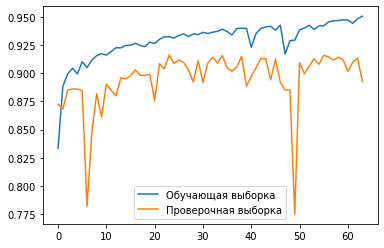

In [6]:
plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Проверочная выборка')
plt.legend()
plt.show()

In [ ]:
model.save('segment.h5')

### Проверка

Количество окон - 54


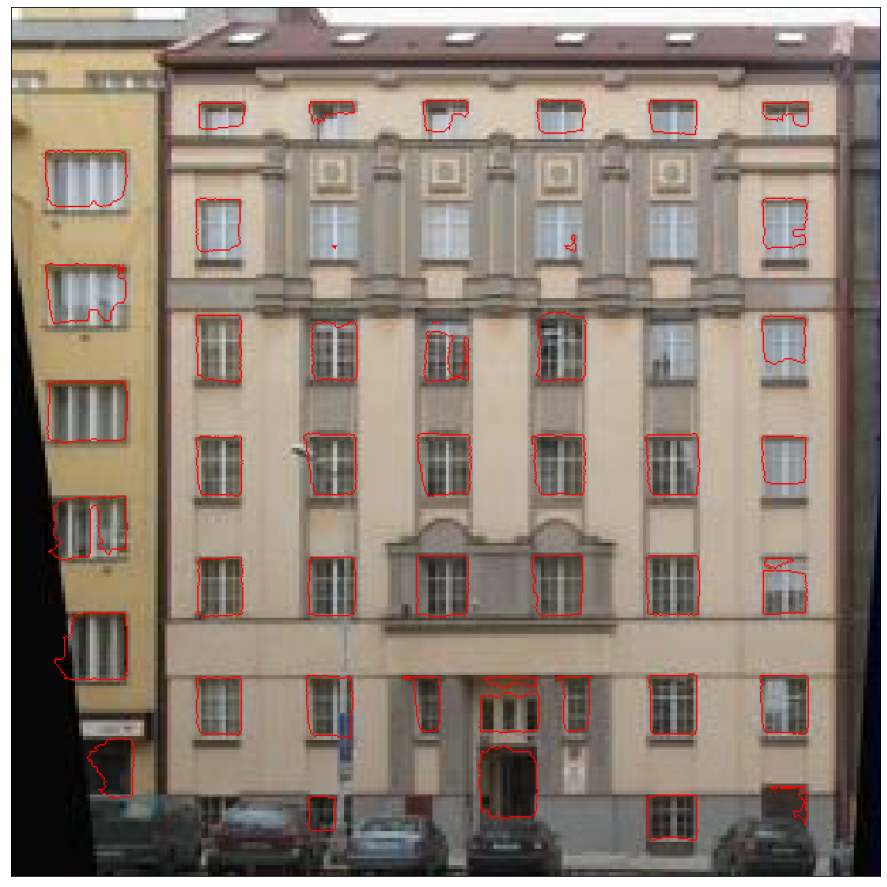

In [10]:
#model = load_model('segment.h5')
fname = '/content/drive/MyDrive/mindset/testA/1.jpg'
x_test = np.expand_dims(img_to_array(load_img(fname,
                                      target_size=(640, 640))) / 255., axis=0)
y_pred = model.predict(x_test, verbose=0)
y_test = np.uint8(y_pred[0] * 255)
res, img = cv2.threshold(y_test, 120, 255, cv2.THRESH_BINARY)
original = x_test[0].copy()
contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('Количество окон -', len(contours))
cv2.drawContours(original, contours, -1, (255, 0, 0))
plt.figure(figsize=(16, 16))
plt.imshow(original)
plt.xticks([])
plt.yticks([])
plt.show()